<a href="https://colab.research.google.com/github/VKSi/2020_12_DataCompetitions_Course/blob/main/HW_6_FeaturesSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Engineering, Feature Selection, part II

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.     

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.     

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.     

Задание 3: использовать permutation importance, выполнить задание 1 и 2.     

Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.     

Задание 5: использовать shap, выполнить задание 1 и 2.     

Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

# Общая (подготовительная) часть

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 77kB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files, drive
import pickle
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from typing import List, Tuple
import catboost as cb

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
PATH = "gdrive/My Drive/AI/GB/Kaggle/"
object_path = "gdrive/My Drive/AI/GB/Kaggle/objects/"

In [ ]:
def save_obj(obj, name: str):
    path = object_path + name + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    return path


def load_obj(name: str):
    with open(object_path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
data = pd.read_csv(object_path + "HW_5_FI_I_data.csv", index_col=0)

In [ ]:
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 180000 rows, 446 cols


In [ ]:
data.iloc[:5, :5]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD
0,2987000,0,2017-12-02 00:00:00,68.5,W
1,2987001,0,2017-12-02 00:00:01,29.0,W
2,2987002,0,2017-12-02 00:01:09,59.0,W
3,2987003,0,2017-12-02 00:01:39,50.0,W
4,2987004,0,2017-12-02 00:01:46,50.0,H


In [ ]:
REST_FEATURES = data.columns
INITIAL_FEATURES = REST_FEATURES.copy()

ID = 'TransactionID'
REST_FEATURES = list(set(REST_FEATURES) - set([ID]))

TARGET = 'isFraud'
REST_FEATURES = list(set(REST_FEATURES) - set([TARGET]))

NUMERICAL_FEATURES = data[REST_FEATURES].select_dtypes(include=[np.number]).columns.to_list()
REST_FEATURES = list(set(REST_FEATURES) - set(NUMERICAL_FEATURES))

CATEGORICAL_FEATURES = REST_FEATURES

INITIAL_CATEGORICAL_FEATURES = CATEGORICAL_FEATURES.copy()

REST_FEATURES = None

In [ ]:
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].astype('str')

# Задание 0:
выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.     

Используем тот-же подход, что и в предыдущем занятии.     
PS: так как на момент подготовки задания пока не понял в чем проблема с этой схемой, использую ее. Можно использовать OOF в чистом виде.

In [ ]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 4,
    "reg_lambda": 100,
    "class_weights":[3, 97], 
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

In [ ]:
model = cb.CatBoostClassifier(**cb_params)

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5)

In [ ]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        train_pool = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
        valid_pool = cb.Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)
        estimator.fit(train_pool, eval_set=[train_pool, valid_pool])

        y_train_pred = estimator.predict_proba(X_train)[:, 1]
        y_valid_pred = estimator.predict_proba(X_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [ ]:
def my_validation(X, y, task_n):
  
  estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = \
    make_cross_validation(X, y, model, metric=roc_auc_score, cv_strategy=cv_strategy)
  save_obj(estimators, f'estimators_HW6_task{task_n}')
  proba = np.zeros((len(estimators), X.shape[0]))
  for i, est in enumerate(estimators):
    proba[i, :] = est.predict_proba(X)[:, 1]
  proba_train = np.mean(proba, axis = 0)
  train_score = roc_auc_score(y, proba_train)
  print(f'ROC AUC train score = {round(train_score, 3)}')
  return estimators    

In [ ]:
X = data.drop([ID, TARGET], axis='columns')
y = data[TARGET]

In [ ]:
# my_validation(X, y, 0)

0:	test: 0.8812012	test1: 0.7778466	best: 0.7778466 (0)	total: 938ms	remaining: 2h 36m 20s
500:	test: 0.9841130	test1: 0.9160219	best: 0.9160219 (500)	total: 6m 52s	remaining: 2h 10m 19s
1000:	test: 0.9905492	test1: 0.9248336	best: 0.9248336 (1000)	total: 13m 41s	remaining: 2h 3m 4s
1500:	test: 0.9927133	test1: 0.9273006	best: 0.9273147 (1498)	total: 20m 25s	remaining: 1h 55m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9287897244
bestIteration = 1901

Shrink model to first 1902 iterations.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9937, valid-score = 0.9288
0:	test: 0.8682171	test1: 0.7735381	best: 0.7735381 (0)	total: 1.02s	remaining: 2h 50m 17s
500:	test: 0.9847557	test1: 0.9298787	best: 0.9298964 (499)	total: 6m 48s	remaining: 2h 9m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9356001199
bestIteration = 833

Shrink model to first 834 iterations.
Fold: 2, train-observations = 144000, valid-ob

CV-results train: 0.9776 +/- 0.016     
CV-results valid: 0.9075 +/- 0.025     
OOF-score = 0.8968     
ROC AUC train score = 0.976     

In [ ]:
estimators_HW6_task0 = load_obj('estimators_HW6_task0')

# Задание 1:
использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [ ]:
def feature_importance_table_builtin(estimators, features):
  importance_df = pd.DataFrame(index = features)
  for i, est in enumerate(estimators):
    importance_df.loc[:, f'est_{i + 1}'] = est.feature_importances_
  importance_df['MEAN']=importance_df.mean(axis=1)
  importance_df['STD']=importance_df.std(axis=1)
  importance_df = importance_df.sort_values(by='MEAN', ascending=False)
  return importance_df


In [ ]:
importance_table = feature_importance_table_builtin(estimators=estimators_HW6_task0, features=X.columns)

In [ ]:
importance_table.head(10)

,est_1,est_2,est_3,est_4,est_5,MEAN,STD
card1_addr2_card5_card3_addr1_card2,16.269246,16.269246,16.269246,16.269246,16.269246,16.269246,0.000000e+00
C14,4.637145,4.637145,4.637145,4.637145,4.637145,4.637145,9.729507e-16
M4,4.124764,4.124764,4.124764,4.124764,4.124764,4.124764,0.000000e+00
P_emaildomain,3.760362,3.760362,3.760362,3.760362,3.760362,3.760362,1.986027e-16
M5,3.453758,3.453758,3.453758,3.453758,3.453758,3.453758,4.440892e-16
TransactionDT_day,2.997869,2.997869,2.997869,2.997869,2.997869,2.997869,0.000000e+00
C1,2.903509,2.903509,2.903509,2.903509,2.903509,2.903509,0.000000e+00
C13,2.883819,2.883819,2.883819,2.883819,2.883819,2.883819,0.000000e+00
M6,1.779589,1.779589,1.779589,1.779589,1.779589,1.779589,2.220446e-16
R_emaildomain,1.779424,1.779424,1.779424,1.779424,1.779424,1.779424,9.930137e-17


Text(0.5, 1.0, 'Built-in feature importance')

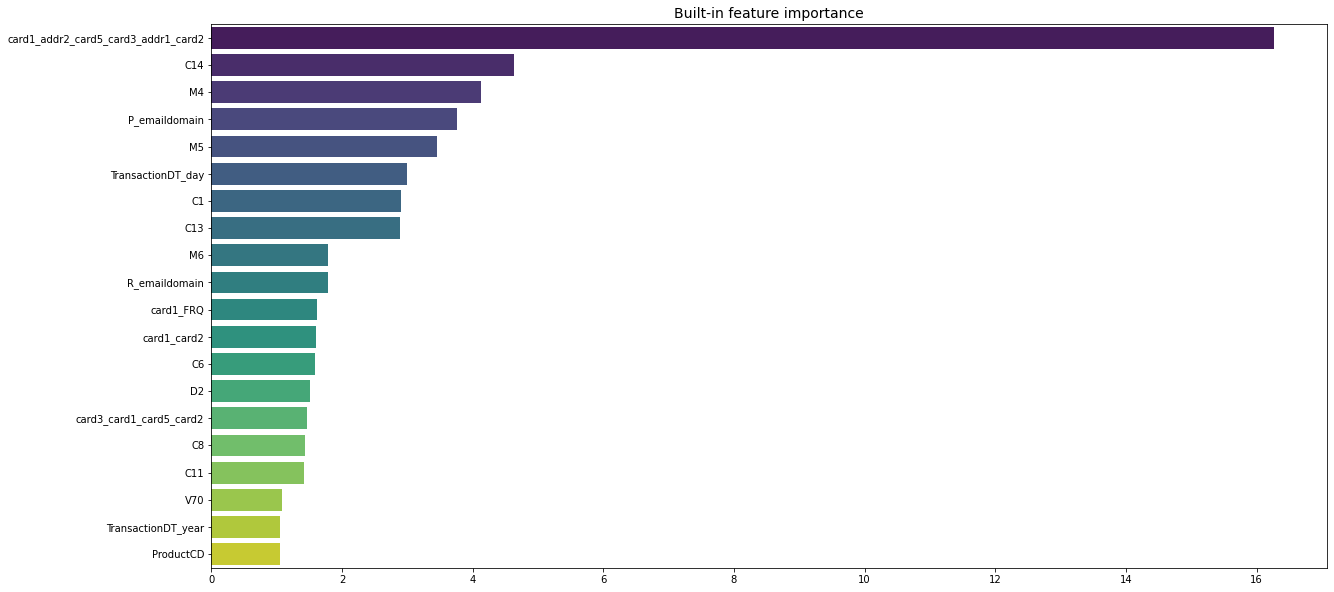

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(y=importance_table.index.to_list()[:20], x=importance_table.iloc[:20, :].MEAN.values, palette="viridis")
plt.title("Built-in feature importance", size=14)

# Задание 2:
удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

Удалим все признаки, важность которых меньше 3-х стандартных отклонений (и ниже нуля в том числе)

In [ ]:
mask = ~(importance_table.MEAN <= 3*importance_table.STD)
df = importance_table[mask].sort_values(by='MEAN', ascending=False)
df

,est_1,est_2,est_3,est_4,est_5,MEAN,STD
card1_addr2_card5_card3_addr1_card2,1.626925e+01,1.626925e+01,1.626925e+01,1.626925e+01,1.626925e+01,1.626925e+01,0.000000e+00
C14,4.637145e+00,4.637145e+00,4.637145e+00,4.637145e+00,4.637145e+00,4.637145e+00,9.729507e-16
M4,4.124764e+00,4.124764e+00,4.124764e+00,4.124764e+00,4.124764e+00,4.124764e+00,0.000000e+00
P_emaildomain,3.760362e+00,3.760362e+00,3.760362e+00,3.760362e+00,3.760362e+00,3.760362e+00,1.986027e-16
M5,3.453758e+00,3.453758e+00,3.453758e+00,3.453758e+00,3.453758e+00,3.453758e+00,4.440892e-16
...,...,...,...,...,...,...,...
V254,5.922680e-07,5.922680e-07,5.922680e-07,5.922680e-07,5.922680e-07,5.922680e-07,0.000000e+00
V115,2.821775e-07,2.821775e-07,2.821775e-07,2.821775e-07,2.821775e-07,2.821775e-07,5.799238e-23
V124,1.587255e-07,1.587255e-07,1.587255e-07,1.587255e-07,1.587255e-07,1.587255e-07,2.899619e-23
V79,5.747778e-09,5.747778e-09,5.747778e-09,5.747778e-09,5.747778e-09,5.747778e-09,9.061310e-25


In [ ]:
important_features = df.index.to_list()
CATEGORICAL_FEATURES = list(set(INITIAL_CATEGORICAL_FEATURES).intersection(set(important_features)))

In [ ]:
# estimators = my_validation(X[important_features], y, 2)

0:	test: 0.8722446	test1: 0.7536879	best: 0.7536879 (0)	total: 1.12s	remaining: 3h 6m 9s
500:	test: 0.9798300	test1: 0.9128838	best: 0.9128954 (499)	total: 6m	remaining: 1h 53m 47s
1000:	test: 0.9886608	test1: 0.9221560	best: 0.9221757 (999)	total: 12m 2s	remaining: 1h 48m 17s
1500:	test: 0.9911938	test1: 0.9244308	best: 0.9244308 (1500)	total: 17m 56s	remaining: 1h 41m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9246451636
bestIteration = 1602

Shrink model to first 1603 iterations.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9915, valid-score = 0.9246
0:	test: 0.8135494	test1: 0.7888363	best: 0.7888363 (0)	total: 822ms	remaining: 2h 16m 54s
500:	test: 0.9793422	test1: 0.9262488	best: 0.9263667 (497)	total: 5m 57s	remaining: 1h 52m 54s
1000:	test: 0.9880558	test1: 0.9336662	best: 0.9336662 (1000)	total: 11m 55s	remaining: 1h 47m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9354020459
bestIterat

CV-results train: 0.9653 +/- 0.025     
CV-results valid: 0.8976 +/- 0.032     
OOF-score = 0.8905     
ROC AUC train score = 0.957

# Задание 3:
использовать permutation importance, выполнить задание 1 и 2.

Возьмем функции с вебинара и добавим к ним свою функцию для расчета таблицы по всем эстиматорам:

In [ ]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in x_valid.columns:
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [ ]:
def feature_importance_table_permutation(estimators, metric, X, y):
  features = X.columns
  importance_df = pd.DataFrame(index = features)
  for i, est in enumerate(estimators):
    scores, delta = calculate_permutation_importance(est, metric, X, y)
    importance_df.loc[:, f'est_{i + 1}'] = delta
    print(i)
  importance_df['MEAN']=importance_df.mean(axis=1)
  importance_df['STD']=importance_df.std(axis=1)
  importance_df = importance_df.sort_values(by='MEAN', ascending=False)
  return importance_df

In [ ]:
# importance_table = feature_importance_table_permutation(estimators_HW6_task0, roc_auc_score, X, y)

0
1
2
3
4


Text(0.5, 1.0, 'Permutation feature importance')

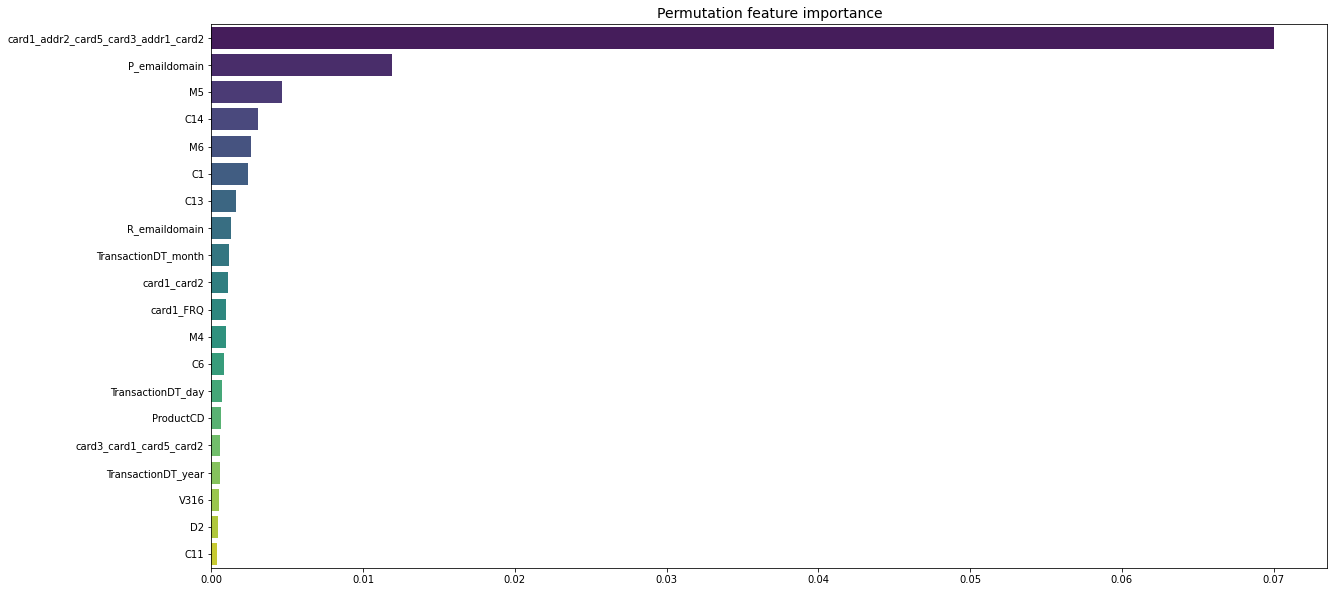

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(y=importance_table.index.to_list()[:20], x=importance_table.MEAN.values[:20], palette="viridis")
plt.title("Permutation feature importance", size=14)

In [ ]:
mask = ~(importance_table.MEAN <= 3*importance_table.STD)
df = importance_table[mask].sort_values(by='MEAN', ascending=False)
df

,est_1,est_2,est_3,est_4,est_5,MEAN,STD
card1_addr2_card5_card3_addr1_card2,7.047919e-02,7.051818e-02,7.104598e-02,6.951298e-02,6.861170e-02,7.003360e-02,8.661549e-04
P_emaildomain,1.188985e-02,1.216259e-02,1.175115e-02,1.173143e-02,1.186786e-02,1.188058e-02,1.541286e-04
M5,4.452111e-03,4.809751e-03,4.778351e-03,4.697854e-03,4.670179e-03,4.681649e-03,1.255731e-04
C14,3.171407e-03,2.917351e-03,3.224130e-03,2.709758e-03,3.237497e-03,3.052029e-03,2.066669e-04
M6,2.547765e-03,2.536471e-03,2.692951e-03,2.675236e-03,2.749922e-03,2.640469e-03,8.408653e-05
...,...,...,...,...,...,...,...
V292,1.700873e-06,1.717559e-06,1.333778e-06,2.952333e-06,2.056844e-06,1.952277e-06,5.498879e-07
V236,1.430558e-06,1.566272e-06,7.909226e-07,7.308526e-07,1.377162e-06,1.179153e-06,3.475540e-07
V17,2.336058e-08,2.781022e-08,2.224818e-08,2.892263e-08,1.557372e-08,2.358307e-08,4.740480e-09
V305,1.891095e-08,2.336058e-08,1.446131e-08,8.899270e-09,2.113577e-08,1.735358e-08,5.150825e-09


In [ ]:
important_features = df.index.to_list()
CATEGORICAL_FEATURES = list(set(INITIAL_CATEGORICAL_FEATURES).intersection(set(important_features)))

In [ ]:
# estimators = my_validation(X[important_features], y, 3)

0:	test: 0.7823365	test1: 0.7137234	best: 0.7137234 (0)	total: 673ms	remaining: 1h 52m 13s
500:	test: 0.9806425	test1: 0.9095469	best: 0.9095469 (500)	total: 4m 34s	remaining: 1h 26m 39s
1000:	test: 0.9878710	test1: 0.9191629	best: 0.9191629 (1000)	total: 9m	remaining: 1h 21m
1500:	test: 0.9907136	test1: 0.9219333	best: 0.9219360 (1494)	total: 13m 29s	remaining: 1h 16m 21s
2000:	test: 0.9924936	test1: 0.9245918	best: 0.9246086 (1992)	total: 17m 58s	remaining: 1h 11m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9263854663
bestIteration = 2428

Shrink model to first 2429 iterations.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9933, valid-score = 0.9264
0:	test: 0.7931951	test1: 0.7497312	best: 0.7497312 (0)	total: 659ms	remaining: 1h 49m 46s
500:	test: 0.9819759	test1: 0.9255766	best: 0.9255766 (500)	total: 4m 31s	remaining: 1h 25m 42s
1000:	test: 0.9887196	test1: 0.9337461	best: 0.9337574 (998)	total: 8m 58s	remaining: 1h 2

### Результат  
CV-results train: 0.9815 +/- 0.015     
CV-results valid: 0.9092 +/- 0.025     
OOF-score = 0.8833     
ROC AUC train score = 0.979

# Задание 4:
использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.
# Это задание пропустил ((((. См. следующее.

In [ ]:
!pip install boostaroota

In [ ]:
from boostaroota import BoostARoota

In [ ]:
br = BoostARoota(metric='auc')
br.fit(X, y)

In [ ]:
br.keep_vars_

In [ ]:
estimators = my_validation(br.transform(X), y, 4)

### Результат 

# Задание 5:
использовать shap, выполнить задание 1 и 2.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
def feature_importance_table_shap(estimators, X, y):
  features = X.columns
  importance_df = pd.DataFrame(index = features)
  for i, est in enumerate(estimators):
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X, y)
    score = score = shap_values.mean(axis=0)
    importance_df.loc[:, f'est_{i + 1}'] = score
  importance_df['MEAN']=importance_df.mean(axis=1)
  importance_df['STD']=importance_df.std(axis=1)
  importance_df = importance_df.sort_values(by='MEAN', ascending=False)
  return importance_df

In [ ]:
importance_table = feature_importance_table_shap(estimators_HW6_task0, X, y)

In [ ]:
importance_table.head(10)

,est_1,est_2,est_3,est_4,est_5,MEAN,STD
TransactionDT_month,0.126300,0.126300,0.126300,0.126300,0.126300,0.126300,0.000000e+00
TransactionDT_year,0.106683,0.106683,0.106683,0.106683,0.106683,0.106683,0.000000e+00
TransactionDT_dow,0.018652,0.018652,0.018652,0.018652,0.018652,0.018652,0.000000e+00
C1,0.012313,0.012313,0.012313,0.012313,0.012313,0.012313,0.000000e+00
C11,0.010489,0.010489,0.010489,0.010489,0.010489,0.010489,1.900294e-18
M4,0.010271,0.010271,0.010271,0.010271,0.010271,0.010271,0.000000e+00
TransactionDT_day,0.009846,0.009846,0.009846,0.009846,0.009846,0.009846,0.000000e+00
V261,0.004281,0.004281,0.004281,0.004281,0.004281,0.004281,0.000000e+00
C2,0.004161,0.004161,0.004161,0.004161,0.004161,0.004161,0.000000e+00
C6,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570,0.000000e+00


Text(0.5, 1.0, 'SHAP feature importance')

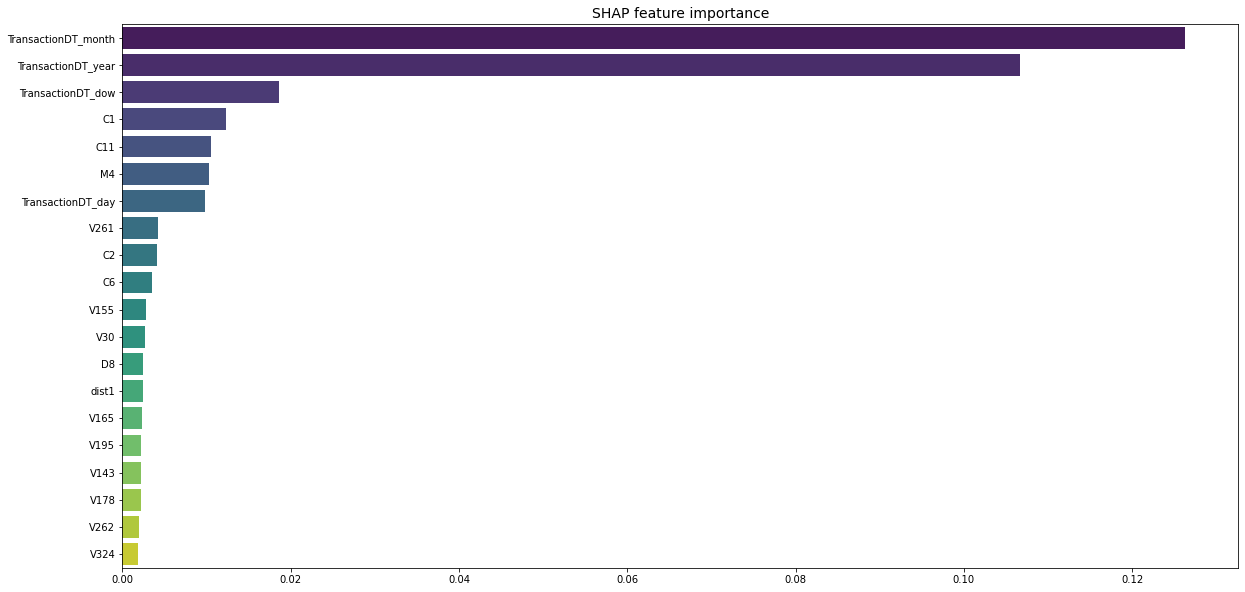

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(y=importance_table.index.to_list()[:20], x=importance_table.iloc[:20, :].MEAN.values, palette="viridis")
plt.title("SHAP feature importance", size=14)

In [ ]:
mask = ~(importance_table.MEAN <= 3*importance_table.STD)
df = importance_table[mask].sort_values(by='MEAN', ascending=False)
df

,est_1,est_2,est_3,est_4,est_5,MEAN,STD
TransactionDT_month,1.262996e-01,1.262996e-01,1.262996e-01,1.262996e-01,1.262996e-01,1.262996e-01,0.000000e+00
TransactionDT_year,1.066827e-01,1.066827e-01,1.066827e-01,1.066827e-01,1.066827e-01,1.066827e-01,0.000000e+00
TransactionDT_dow,1.865242e-02,1.865242e-02,1.865242e-02,1.865242e-02,1.865242e-02,1.865242e-02,0.000000e+00
C1,1.231315e-02,1.231315e-02,1.231315e-02,1.231315e-02,1.231315e-02,1.231315e-02,0.000000e+00
C11,1.048901e-02,1.048901e-02,1.048901e-02,1.048901e-02,1.048901e-02,1.048901e-02,1.900294e-18
...,...,...,...,...,...,...,...
V228,2.537216e-07,2.537216e-07,2.537216e-07,2.537216e-07,2.537216e-07,2.537216e-07,5.799238e-23
V238,1.729410e-07,1.729410e-07,1.729410e-07,1.729410e-07,1.729410e-07,1.729410e-07,0.000000e+00
V115,1.521801e-07,1.521801e-07,1.521801e-07,1.521801e-07,1.521801e-07,1.521801e-07,0.000000e+00
V250,3.333061e-08,3.333061e-08,3.333061e-08,3.333061e-08,3.333061e-08,3.333061e-08,0.000000e+00


In [ ]:
important_features = df.index.to_list()
CATEGORICAL_FEATURES = list(set(INITIAL_CATEGORICAL_FEATURES).intersection(set(important_features)))

In [ ]:
estimators = my_validation(X[important_features], y, 5)

0:	test: 0.7409665	test1: 0.7155773	best: 0.7155773 (0)	total: 272ms	remaining: 45m 15s
500:	test: 0.8991742	test1: 0.8561689	best: 0.8561689 (500)	total: 2m 9s	remaining: 41m
1000:	test: 0.9292586	test1: 0.8702774	best: 0.8703025 (996)	total: 4m 15s	remaining: 38m 21s
1500:	test: 0.9416806	test1: 0.8738153	best: 0.8739311 (1487)	total: 6m 17s	remaining: 35m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8744332598
bestIteration = 1578

Shrink model to first 1579 iterations.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9435, valid-score = 0.8744
0:	test: 0.7493016	test1: 0.7710521	best: 0.7710521 (0)	total: 259ms	remaining: 43m 9s
500:	test: 0.8942811	test1: 0.8787338	best: 0.8787788 (496)	total: 2m 9s	remaining: 40m 49s
1000:	test: 0.9247410	test1: 0.8910230	best: 0.8910230 (1000)	total: 4m 15s	remaining: 38m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8938612257
bestIteration = 1315

Shrink model

### Результат 
CV-results train: 0.8854 +/- 0.047     
CV-results valid: 0.8535 +/- 0.026     
OOF-score = 0.8283     
ROC AUC train score = 0.859

# Задание 6:
построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [ ]:
est = estimators[0]
x_valid = X[important_features]

In [ ]:
explainer = shap.TreeExplainer(est)
shap_values = explainer.shap_values(x_valid, y)

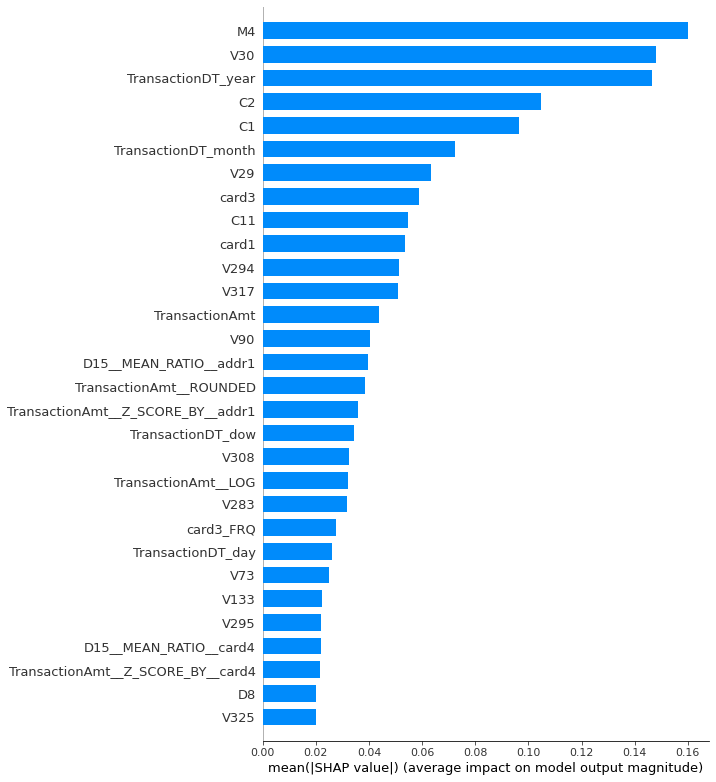

In [ ]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=30)

In [ ]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]
shap_values = explainer.shap_values(features)

Explainer expected value: -0.8653583484401787


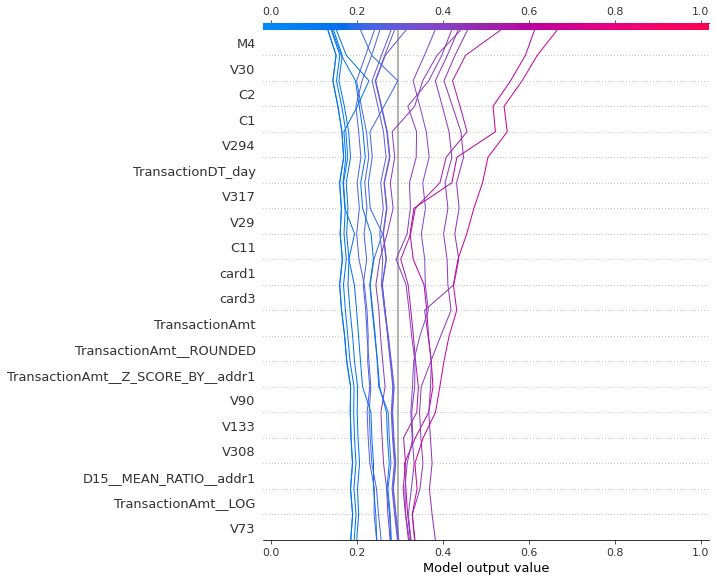

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:10], link="logit")